In [1]:
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2
import matplotlib.pyplot as plt
import face_recognition
import os
from imutils import paths
import pickle
from keras.models import load_model

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

Using TensorFlow backend.


In [3]:
#기분표시 모델
emotion_model_path = 'fer2013_big_XCEPTION.54-0.66.hdf5'

#얼굴 검출모델
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

#나이 분류모델
ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

#성별 분류모델
genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

emotion_labels = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'sad',5:'surprise',6:'neutral'}


detector = dlib.get_frontal_face_detector()
emotion_classifier = load_model(emotion_model_path, compile=False)
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)

emotion_target_size = emotion_classifier.input_shape[1:3]

In [4]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

Detection 0: Left: 37 Top: 79 Right: 162 Bottom: 203
Gender : Male, conf = 0.999


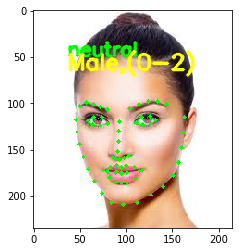

In [5]:
frame = cv2.imread("face.jpg")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)  

for k, d in enumerate(rects):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        shape = predictor(gray, d)
        shape = face_utils.shape_to_np(shape)
        for s in shape:
          cv2.circle(frame, (s[0], s[1]), 2, (0, 255, 0), -1)
        
        x1 = d.left()
        y1 = d.top()
        x2 = d.right()
        y2 = d.bottom()
        
        gray_face = gray[y1:y2, x1:x2]
        gray_face = cv2.resize(gray_face, (emotion_target_size))
        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0) # 앞에 1차원 추가    
        gray_face = np.expand_dims(gray_face, -1) # 뒤에 1차원 추가
    
        emotion_label_arg = np.argmax(emotion_classifier.predict(gray_face))
        emotion_text = emotion_labels[emotion_label_arg]
        
        cv2.putText(frame, emotion_text, (x1, y1 -30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)      
        
        
        face = frame[y1:y2, x1:x2, :]        
        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227),(78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]
        print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        label = "{},{}".format(gender, age)
        cv2.putText(frame, label, (x1, y1-15), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)        
        
        
imshow('', frame)